In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

Let's start with our `numpy` code for a one-hidden layer `network`, `error_gradient` and `mse`.

In [2]:
def network(w, n_inputs, n_hiddens, n_outputs, X, all_outputs=False):
    n_V = (n_inputs + 1) * n_hiddens
    n_W = (n_hiddens + 1) * n_outputs
    V = w[:n_V].reshape((n_inputs + 1, n_hiddens))
    W = w[n_V:].reshape((n_hiddens + 1, n_outputs))
    Z = np.tanh(V[0:1, :] + X @ V[1:, :])
    Y = W[0:1, :] + Z @ W[1:, :]
    return (Y, Z) if all_outputs else Y

def error_gradient(w, n_inputs, n_hiddens, n_outputs, X, T):
    Y, Z = network(w, n_inputs, n_hiddens, n_outputs, X, all_outputs=True)
    n_samples = X.shape[0]
    delta_Y = -2 / (n_samples * n_outputs) * (T - Y)
    Z_hat = np.insert(Z, 0, 1, axis=1)
    dEdW = Z_hat.T @ delta_Y
    
    n_W = (n_hiddens + 1) * n_outputs
    W = w[-n_W:].reshape((n_hiddens + 1, n_outputs))
    delta_Z = (delta_Y @ W[1:, :].T) * (1 - Z**2)
    X_hat = np.insert(X, 0, 1, axis=1)
    dEdV = X_hat.T @ delta_Z
 
    dEdw = np.hstack((dEdV.flatten(), dEdW.flatten()))

    return dEdw

def mse(w, n_inputs, n_hiddens, n_outputs, X, T):
    Y = network(w, n_inputs, n_hiddens, n_outputs, X)
    return np.mean((T - Y)**2)

Now we can write `torch` versions of each.  

Where is the `error_gradient` function???

In [3]:
def network_torch(w, n_inputs, n_hiddens, n_outputs, X, all_outputs=False):
    n_V = (n_inputs + 1) * n_hiddens
    n_W = (n_hiddens + 1) * n_outputs
    V = w[:n_V].reshape((n_inputs + 1, n_hiddens))
    W = w[n_V:].reshape((n_hiddens + 1, n_outputs))
    Z = torch.tanh(V[0:1, :] + X @ V[1:, :])
    Y = W[0:1, :] + Z @ W[1:, :]
    return (Y, Z) if all_outputs else Y

def mse_torch(w, n_inputs, n_hiddens, n_outputs, X, T):
    Y = network_torch(w, n_inputs, n_hiddens, n_outputs, X)
    return torch.mean((T - Y)**2)

Let's test both versions of our code.  Say we have a network with 2 inputs, 3 hidden units, and 2 outputs.  That's $(2+1)\times 3 + (3+1)\times 2 = 9 + 8 = 17$ weights. And let's make 5 samples of random inputs, and for each sample 2 target values which are the two input values multipled and subtracted.

In [4]:
n_inputs = 2
n_hiddens = 3
n_outputs = 2

n_samples = 5

X = np.random.uniform(-1, 1, (n_samples, n_inputs))
T = np.vstack((X[:, 0] * X[:, 1], X[:, 0] - X[:, 1])).T

w_initial = np.random.uniform(-0.1, 0.1, (n_inputs + 1) * n_hiddens + (n_hiddens + 1) * n_outputs)

X.shape, T.shape, w_initial.shape

((5, 2), (5, 2), (17,))

In [5]:
w = np.copy(w_initial)
for i in range(200):
    grad = error_gradient(w, n_inputs, n_hiddens, n_outputs, X, T)
    w -= 0.1 * grad
    if i % 10 == 0:
        error = mse(w, n_inputs, n_hiddens, n_outputs, X, T)
        print(f'{error:.3f}', end=' ')

0.411 0.369 0.360 0.351 0.334 0.302 0.248 0.179 0.116 0.073 0.052 0.042 0.039 0.037 0.037 0.036 0.036 0.036 0.035 0.035 

Okay. Now how about our torch version?

In [6]:
Xt = torch.tensor(X)
Tt = torch.tensor(T)

In [7]:
wt = torch.tensor(w_initial, requires_grad=True)
for i in range(200):
    error = mse_torch(wt, n_inputs, n_hiddens, n_outputs, Xt, Tt)
    error.backward()
    wt -= 0.1 * wt.grad
    wt.grad.zero_()  # because backward() accumulates gradients with each call
    if i % 10 == 0:
        error = mse_torch(wt, n_inputs, n_hiddens, n_outputs, Xt, Tt)
        print(f'{error:.3f}', end=' ')

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

What's up?  Must tell torch that we do not need to track gradients when we update w.

In [8]:
wt = torch.tensor(w_initial, requires_grad=True)
for i in range(200):
    error = mse_torch(wt, n_inputs, n_hiddens, n_outputs, Xt, Tt)
    error.backward()
    with torch.no_grad():
        wt -= 0.1 * wt.grad
        wt.grad.zero_()  
    if i % 10 == 0:
        error = mse_torch(wt, n_inputs, n_hiddens, n_outputs, Xt, Tt)
        print(f'{error:.3f}', end=' ')

0.411 0.369 0.360 0.351 0.334 0.302 0.248 0.179 0.116 0.073 0.052 0.042 0.039 0.037 0.037 0.036 0.036 0.036 0.035 0.035 

Okay.  So we can train neural networks without writing a gradient function. What else is `pytorch` good for?

Well, I'm glad you asked.  The `numpy` package cannot be used to run our matrix computations on a GPU (yet).  But, `torch` can!!

My laptop does not have a GPU.  But, we can start a `jupyter notebook` on a workstation in the CS department that does have a GPU, such as one of the machines in room 120.  See the first lines in `~info/machines`.

Follow these steps:

Log in to the CS machine, such as saturn.cs.colostate.edu.

There, run

    nice jupyter notebook --no-browser --port=8890
    
The `nice` command lowers the priority of your job so you don't interfere with someone who is sitting at that workstation. It is important to **remember to be nice**!

Next, on your laptop, run

    ssh -N -f -L localhost:8891:localhost:8890 <your username>@boston.cs.colostate.edu
    
In your laptop's browser, enter

    localhost:8891
    
You can find more help with this by searching the net for

    run jupyter notebook remotely

In [11]:
torch.cuda.is_available()

True

In [12]:
Xt = torch.tensor(X)
Xt

tensor([[ 0.3586, -0.3668],
        [ 0.5245,  0.1253],
        [-0.7470,  0.7900],
        [ 0.3310,  0.9792],
        [-0.1576,  0.2076]], dtype=torch.float64)

Now you can move the `Xt` tensor to the GPU.

In [13]:
Xt.device

device(type='cpu')

In [14]:
Xt_gpu = Xt.to('cuda')
Xt_gpu.device

device(type='cuda', index=0)

Just how fast is this GPU?

In [15]:
import time

In [16]:
def testmult(n): 
    X = np.random.uniform(-1, 1, (n, n)) 
    Xt = torch.tensor(X) 
    Xt_gpu = torch.tensor(X).to('cuda') 
    
    a = time.time()
    XX = X @ X
    b = time.time()
    print(f'    numpy took {b-a:.5f} seconds')
    
    a = time.time()
    XX = Xt @ Xt
    b = time.time()
    print(f'    torch took {b-a:.5f} seconds')
    
    a = time.time()
    XX_gpu = Xt_gpu @ Xt_gpu
    b = time.time()
    print(f'torch GPU took {b-a:.5f} seconds')
    
    a = time.time()
    Xt_gpu = torch.tensor(X).to('cuda') 
    XX_gpu = Xt_gpu @ Xt_gpu
    XX = XX_gpu.cpu()
    b = time.time()
    print(f'torch GPU took {b-a:.5f} seconds, there and back')
    
    a = time.time()
    Xt_gpu = torch.tensor(X).to('cuda') 
    XX_gpu = Xt_gpu @ Xt_gpu
    # XX = XX_gpu.cpu()
    b = time.time()
    print(f'torch GPU took {b-a:.5f} seconds, there')

In [17]:
testmult(10)

    numpy took 0.00012 seconds
    torch took 0.00046 seconds
torch GPU took 0.49023 seconds
torch GPU took 0.00056 seconds, there and back
torch GPU took 0.00013 seconds, there


In [19]:
testmult(10)

    numpy took 0.00006 seconds
    torch took 0.00056 seconds
torch GPU took 0.00023 seconds
torch GPU took 0.00044 seconds, there and back
torch GPU took 0.00034 seconds, there


In [20]:
testmult(100)

    numpy took 0.00021 seconds
    torch took 0.00043 seconds
torch GPU took 0.00023 seconds
torch GPU took 0.00044 seconds, there and back
torch GPU took 0.00037 seconds, there


In [21]:
testmult(10000)

    numpy took 6.74049 seconds
    torch took 6.86900 seconds
torch GPU took 0.00931 seconds
torch GPU took 1.09208 seconds, there and back
torch GPU took 0.19505 seconds, there


In [22]:
%%writefile optimizers_torch.py

import numpy as np
import time
import torch

def sgd_torch(w, error_f, fargs=[], n_iterations=100, eval_f=lambda x: x,
              learning_rate=0.001, momentum_rate=0.0,
              save_wtrace=False, verbose=False):

    # Clone so we don't destroy the initial w that was passed in
    w = w.clone()
    # Be sure w is setup for gradient calculations
    w.requires_grad = True
    
    startTime = time.time()
    startTimeLastVerbose = startTime
    
    wtrace = [w.clone()] if save_wtrace else None
    ftrace = [eval_f(error_f(w, *fargs))]
    
    w_change = 0

    for iteration in range(n_iterations):

        fnow = error_f(w, *fargs)  # function value to be minimized
        
        # Do all gradient calculations, for gradient of error_f wrt w
        fnow.backward()

        with torch.no_grad():
            w_change = -learning_rate * w.grad + momentum_rate * w_change
            w += w_change
            w.grad.zero_()

        if save_wtrace:
            wtrace.append(clone(w))
        ftrace.append(eval_f(fnow))

        # Occasional printing if verbose=True
        iterations_per_print = n_iterations // 10
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - startTimeLastVerbose
            evalf = eval_f(fnow).item()  # detach().numpy()
            print(f'SGD: Iteration {iteration+1:d} ObjectiveF={evalf:.5f} Seconds={seconds:.3f}')
            startTimeLastVerbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'iterations',
            'time': time.time() - startTime}

Overwriting optimizers_torch.py


In [23]:
import optimizers_torch as opt

In [24]:
def f(x):
    return (x - 1.5)**2

w = torch.tensor([100.5])

result = opt.sgd_torch(w, f, n_iterations=100, learning_rate=0.1, verbose=True)
print('Final w', result['w'].detach().numpy())

SGD: Iteration 10 ObjectiveF=176.55911 Seconds=0.037
SGD: Iteration 20 ObjectiveF=2.03559 Seconds=0.002
SGD: Iteration 30 ObjectiveF=0.02347 Seconds=0.002
SGD: Iteration 40 ObjectiveF=0.00027 Seconds=0.002
SGD: Iteration 50 ObjectiveF=0.00000 Seconds=0.002
SGD: Iteration 60 ObjectiveF=0.00000 Seconds=0.002
SGD: Iteration 70 ObjectiveF=0.00000 Seconds=0.002
SGD: Iteration 80 ObjectiveF=0.00000 Seconds=0.002
SGD: Iteration 90 ObjectiveF=0.00000 Seconds=0.002
SGD: Iteration 100 ObjectiveF=0.00000 Seconds=0.002
Final w [1.5000002]


In [25]:
w = torch.tensor([100.5]).to('cuda')

result = opt.sgd_torch(w, f, n_iterations=100, learning_rate=0.1, verbose=True)

print('Final w', result['w'].detach().numpy())

SGD: Iteration 10 ObjectiveF=176.55911 Seconds=0.246
SGD: Iteration 20 ObjectiveF=2.03559 Seconds=0.007
SGD: Iteration 30 ObjectiveF=0.02347 Seconds=0.005
SGD: Iteration 40 ObjectiveF=0.00027 Seconds=0.005
SGD: Iteration 50 ObjectiveF=0.00000 Seconds=0.006
SGD: Iteration 60 ObjectiveF=0.00000 Seconds=0.005
SGD: Iteration 70 ObjectiveF=0.00000 Seconds=0.006
SGD: Iteration 80 ObjectiveF=0.00000 Seconds=0.006
SGD: Iteration 90 ObjectiveF=0.00000 Seconds=0.006
SGD: Iteration 100 ObjectiveF=0.00000 Seconds=0.006


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [26]:
print('Final w', result['w'].cpu().detach().numpy())

Final w [1.5000002]


Okay, let's get back to training neural networks, now with our `sgd_torch` implementation.

In [27]:
n_inputs = 2
n_hiddens = 3
n_outputs = 2

n_samples = 500  # Try different values here to see how many we need to show advantage of GPU

X = np.random.uniform(-1, 1, (n_samples, n_inputs))
T = np.vstack((X[:, 0] * X[:, 1], X[:, 0] - X[:, 1])).T

w_initial = np.random.uniform(-0.1, 0.1, (n_inputs + 1) * n_hiddens + (n_hiddens + 1) * n_outputs)

X.shape, T.shape, w_initial.shape

((500, 2), (500, 2), (17,))

In [28]:
Xt = torch.tensor(X)
Tt = torch.tensor(T)
w = torch.tensor(w_initial)  # to cuda 

result = opt.sgd_torch(w, mse_torch, [n_inputs, n_hiddens, n_outputs, Xt, Tt], 
                       n_iterations=1000, learning_rate=0.1, verbose=True)


SGD: Iteration 100 ObjectiveF=0.06211 Seconds=0.212
SGD: Iteration 200 ObjectiveF=0.05681 Seconds=0.050
SGD: Iteration 300 ObjectiveF=0.05638 Seconds=0.053
SGD: Iteration 400 ObjectiveF=0.05569 Seconds=0.049
SGD: Iteration 500 ObjectiveF=0.05445 Seconds=0.048
SGD: Iteration 600 ObjectiveF=0.05213 Seconds=0.050
SGD: Iteration 700 ObjectiveF=0.04812 Seconds=0.049
SGD: Iteration 800 ObjectiveF=0.04216 Seconds=0.048
SGD: Iteration 900 ObjectiveF=0.03480 Seconds=0.048
SGD: Iteration 1000 ObjectiveF=0.02740 Seconds=0.049


In [29]:
Xt = torch.tensor(X).to('cuda')
Tt = torch.tensor(T).to('cuda')
w = torch.tensor(w_initial).to('cuda')

result = opt.sgd_torch(w, mse_torch, [n_inputs, n_hiddens, n_outputs, Xt, Tt], 
                       n_iterations=1000, learning_rate=0.1, verbose=True)


SGD: Iteration 100 ObjectiveF=0.06211 Seconds=0.164
SGD: Iteration 200 ObjectiveF=0.05681 Seconds=0.162
SGD: Iteration 300 ObjectiveF=0.05638 Seconds=0.167
SGD: Iteration 400 ObjectiveF=0.05569 Seconds=0.162
SGD: Iteration 500 ObjectiveF=0.05445 Seconds=0.163
SGD: Iteration 600 ObjectiveF=0.05213 Seconds=0.162
SGD: Iteration 700 ObjectiveF=0.04812 Seconds=0.165
SGD: Iteration 800 ObjectiveF=0.04216 Seconds=0.165
SGD: Iteration 900 ObjectiveF=0.03480 Seconds=0.165
SGD: Iteration 1000 ObjectiveF=0.02740 Seconds=0.161


In [30]:
Yt = network_torch(result['w'], n_inputs, n_hiddens, n_outputs, Xt)
Yt[:5, :]

tensor([[ 0.1046,  0.4573],
        [ 0.0437,  0.7114],
        [ 0.1476, -0.0641],
        [ 0.0213,  0.7956],
        [-0.1655, -1.2420]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward>)

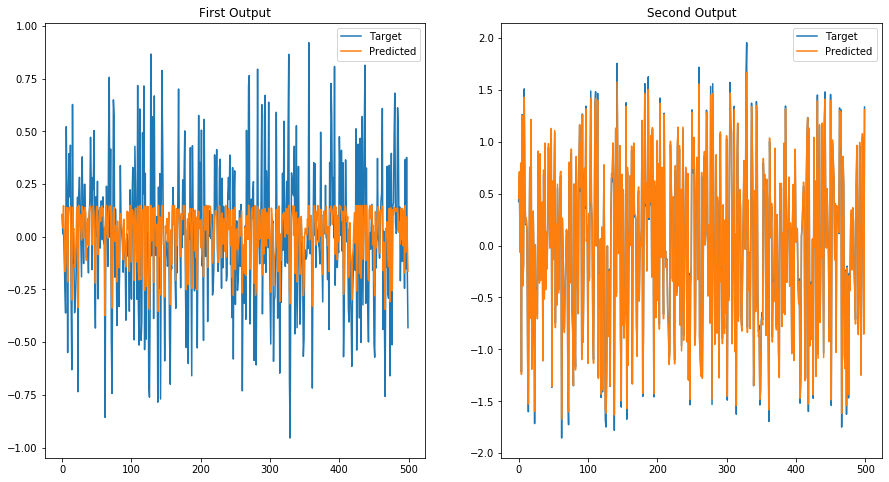

In [31]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(Tt[:, 0].cpu(), label='Target')
plt.plot(Yt[:, 0].cpu().detach(), label='Predicted')
plt.legend()
plt.title('First Output')

plt.subplot(1, 2, 2)
plt.plot(Tt[:, 1].cpu(), label='Target')
plt.plot(Yt[:, 1].cpu().detach(), label='Predicted')
plt.legend()
plt.title('Second Output');
